# Packages, dataset, and variable names

In [338]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [339]:
# Datasets
train = pd.read_csv('train.csv').drop(columns='Id')
test = pd.read_csv('test.csv').drop(columns='Id')

In [340]:
# Variables
response = ['price']

categorical = ['host_is_superhost', 'host_identity_verified', 'property_type', 'room_type',
               'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

continuous = ['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people',
              'minimum_nights','maximum_nights']

discrete = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

reviews = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

coordinates = ['latitude', 'longitude']

predictors = categorical + continuous + discrete + reviews + coordinates

# EDA
Minimal EDA in this Notebook - see previous notebooks

In [341]:
# EDA to help determine logs
#def hist(series):
#    fig, ax = plt.subplots()
#    sns.distplot(series, ax=ax,
#                 hist_kws={'alpha': 0.75,
#                           'edgecolor':'black',
#                           'color': sns.color_palette('Greens')[-1]},  
#                 kde_kws={'color': 'black', 'alpha': 0.9})
#    return plt.show()
#
#for i in data.columns:
#    hist(data[i])

In [342]:
## Potential interactions - update continuous and dummy variable accordingly
#sns.lmplot('security_deposit', 'price', data=data_temp, hue='is_business_travel_ready', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
#plt.show()

# Data Processing / Engineering / Scaling

In [343]:
def impute(data):
    '''
    Imputes missing data in test / train sets for Airbnb data
    '''
    
    # Categoricals
    data['host_is_superhost'].fillna(value='f', inplace=True)
    data['host_identity_verified'].fillna(value='f', inplace=True)

    # No costs
    data['security_deposit'].fillna(value=0, inplace=True)
    data['cleaning_fee'].fillna(value=0, inplace=True)

    # Medians
    for i in discrete+continuous:
        data[i].fillna(value=np.nanmedian(data[i]), inplace=True)

    # Reviews
    zero_reviews = data[reviews].loc[data['number_of_reviews'] == 0]
    zero_reviews.fillna(value=0, inplace=True)

    nonzero_reviews = data[reviews].loc[data['number_of_reviews'] > 0]
    data_reviews = pd.concat([zero_reviews, nonzero_reviews], axis=0).sort_index()

    for i in data_reviews.columns:
        data_reviews[i].fillna(value=np.nanmedian(data_reviews[i]), inplace=True)

    data = data.drop(columns=data[reviews].columns)
    data = pd.concat([data, data_reviews], axis=1)
    
    return data

In [344]:
from math import radians, cos, sin, asin, sqrt

def great_circle_dist(lat1, lon1, lat2, lon2):
    '''
    Function to calculate great circle distance between two points, using Haversine formula
    '''
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    dist = 6371 * c # in km's
    return dist

In [345]:
def engineer(data):
    '''
    Feature engineering (encoding, transforming, and creating new variables)
    '''
    
    # One-hot encoding
    dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)
    data = data.drop(columns=data[categorical].columns)
    data = pd.concat([data, dummies], axis=1)

    # Distance
    syd_lat, syd_lon = -33.8587377, 151.210686 # Syd Opera House

    distance = []
    for i in np.arange(len(data)):
        lat = data['latitude'].iloc[i]
        lon = data['longitude'].iloc[i]

        dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
        distance.append(dist)

    distance = pd.DataFrame(distance, columns=['distance'])
    data = pd.concat([data, distance], axis=1)
    
    # New predictors
    data['has_review'] = (data.number_of_reviews > 0).astype(int)
    data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']
    data['beds_per_person'] = data['beds'] / data['accommodates']
    data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']
    data['bedrooms_per_person'] = data['bedrooms'] / data['accommodates']
    data['beds_per_bedrooms'] = data['beds'] / data['bedrooms']
    data['bathrooms_per_bedroom'] = data['bathrooms'] / data['bedrooms']
    data['extra_people_vs_accommodates'] = data['extra_people'] / data['accommodates']

    review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication', 'review_scores_location', 'review_scores_value']
    data['average_review'] = data[review_combination].mean(axis=1)
    
    # Interactions (based on EDA)
    data['fee_per_person:is_business_tavel_ready'] = data['fee_per_person'] * data['is_business_travel_ready_t']
    data['cleaning_fee:is_business_tavel_ready'] = data['cleaning_fee'] * data['is_business_travel_ready_t']
    data['security_deposit:is_business_tavel_ready'] = data['security_deposit'] * data['is_business_travel_ready_t']
    data['accommodates:is_business_tavel_ready'] = data['accommodates'] * data['is_business_travel_ready_t']
    
    data['fee_per_person:instant_bookable'] = data['fee_per_person'] * data['instant_bookable_t']
    data['review_scores_rating:instant_bookable'] = data['review_scores_rating'] * data['instant_bookable_t']
    data['average_review:instant_bookable'] = data['review_scores_rating'] * data['instant_bookable_t']
    
    data['fee_per_person:host_identity_verified'] = data['fee_per_person'] * data['host_identity_verified_t']
    data['security_deposit:host_identity_verified'] = data['security_deposit'] * data['host_identity_verified_t']
    data['review_scores_rating:host_identity_verified_t'] = data['review_scores_rating'] * data['host_identity_verified_t']
    
    data['cleaning_fee:has_review'] = data['cleaning_fee'] * data['has_review']
    data['security_deposit:has_review'] = data['security_deposit'] * data['has_review']
    data['fee_per_person:has_review'] = data['fee_per_person'] * data['has_review']
    data['distance:has_review'] = data['distance'] * data['has_review']
    
    data['accommodates:host_is_superhost_t'] = data['accommodates'] * data['host_is_superhost_t']
    data['extra_people:host_is_superhost_t'] = data['extra_people'] * data['host_is_superhost_t']
        
    # Log transformations (determined with EDA)
    pred_to_log = ['security_deposit', 'cleaning_fee', 'minimum_nights', 'maximum_nights',
                   'number_of_reviews', 'reviews_per_month', 'fee_per_person', 'distance',
                   'review_scores_rating', 'average_review']
    for i in pred_to_log:
        data[str('log_')+i] = np.log(data[i])
 
    # Data to drop (leave commented to not drop
    #data = data.drop(columns=review_combination)
    #data = data.drop(columns=coordinates)
    #data = data.drop(columns=pred_to_log)
    try:
        data = data.drop(columns='property_type_Timeshare') # doesn't exist in test dataset
    except:
        pass

    # Necessary due to new predictors that divided by zero, etc.
    data = data.replace([np.inf, -np.inf], 0)
    data = data.replace([np.nan], 0)
    
    return data

In [ ]:
# MORE INTERATIONS?
# reviews per month:instant bookable
# minimum nights less maximum nights?

In [346]:
def process(data):
    data = impute(data)
    data = engineer(data)
    
    return data

In [361]:
# 1. Run processing
train_processed = process(train)
test_processed = process(test)

response = 'price'
predictors = [x for x in list(train_processed.columns) if x not in response]

# 2. Get the scaler for scaling train / test
scaler = StandardScaler().fit(train_processed[predictors])

# 3. Scaler for train / test
from sklearn.preprocessing import StandardScaler

def scale(data):
    data_scaled = scaler.transform(data[predictors])
    data = pd.DataFrame(data_scaled, columns=predictors)
    
    return data

# 4. Scale and split
X_train = scale(train_processed) # removes response
y_train = np.log(train_processed['price']) # logged

X_test = scale(test_processed)

In [348]:
# Calculating VIF for multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_processed[predictors].as_matrix()
VIF = pd.DataFrame([np.sqrt(variance_inflation_factor(X,j)) for j in range(len(predictors))], index=predictors, columns=['SQRT(VIF)'])

VIF.sort_values(by='SQRT(VIF)', ascending=False).head(20)

,SQRT(VIF)
average_review:instant_bookable,inf
review_scores_accuracy,inf
review_scores_rating:instant_bookable,inf
average_review,inf
review_scores_value,inf
review_scores_location,inf
review_scores_communication,inf
review_scores_checkin,inf
review_scores_cleanliness,inf
longitude,523.680105


# Models

In [349]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [317]:
# Linear Regression

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [318]:
%%time
# KNN

model = KNeighborsRegressor() 
    
tuning_parameters = {
    'n_neighbors': np.arange(1, 51),
}

knn_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
knn_search.fit(X_train, y_train)
knn = knn_search.best_estimator_

print('Best parameters: {}'.format(knn_search.best_params_))

Best parameters: {'n_neighbors': 15}
Wall time: 4.67 s


In [319]:
# Lasso

lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

In [320]:
# Ridge

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.505549179068098e-05, 4.026818575356734e-05, 4.625599873383782e-05, 5.313418965430448e-05, 6.103515625e-05, 7.011098358136196e-05, 8.053637150713468e-05, 9.251199746767564e-0...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [321]:
# Elastic Net

enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

In [322]:
%%time
# Regression Tree

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20],
    'max_depth': np.arange(1, 30),
}

tree_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_

print('Best parameters:', tree_search.best_params_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 10}
Wall time: 4.02 s


In [323]:
%%time
# Bagging

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)

Wall time: 4.58 s


In [324]:
%%time
# Random Forest

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_

print('Best parameters:', rf_search.best_params_)

Best parameters: {'max_features': 56, 'min_samples_leaf': 10}
Wall time: 1min 9s


In [325]:
rf.n_estimators = 500
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=56, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [326]:
%%time
# SKLearn Boosting

model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

# NB: too computationally expensive to Grid Search from boosting onwards
gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, y_train)
gb = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_)

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
Wall time: 2min 8s


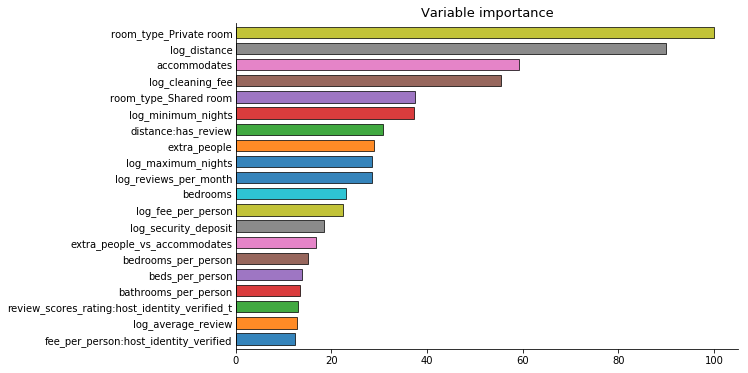

In [327]:
plot_feature_importance(gb, predictors)
plt.show()

In [328]:
%%time
# XGBoost

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, y_train)
xbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_)

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.01}
Wall time: 1min 54s


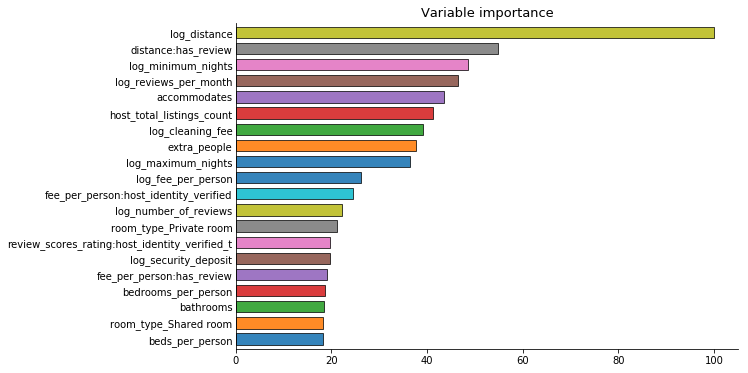

In [329]:
from statlearning import plot_feature_importance

plot_feature_importance(xbst, labels=predictors)
plt.show()

In [330]:
%%time
dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 4, 
    'learning_rate': 0.01, 
    'subsample': 0.6,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round=1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

Selected number of boosting iterations: 594
RMSE (CV): 0.3790
Wall time: 26 s


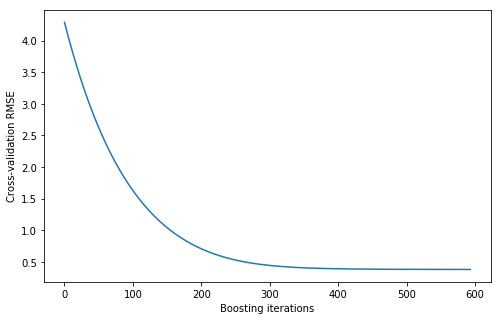

In [331]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
plt.show()

In [332]:
%%time
# LightGBM

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=50, cv=10, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, y_train)
lbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_)

Best parameters found by randomised search: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}
Wall time: 2min 49s


In [333]:
%%time
# Adaptive Boosting

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)
gb_search.fit(X_train, resid)
abst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_)

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.01}
Wall time: 31.8 s


# Cross-validation, model stacking, and predicting

In [334]:
%%time
from sklearn.model_selection import cross_val_score

def score(method):
    '''
    Function to return RMSE for model
    '''
    score = np.mean(np.sqrt(-cross_val_score(method, X_train, y_train, scoring='neg_mean_squared_error', cv=5)))
    return score

columns = ['CV RMSE']
rows = ['OLS', 'KNN', 'Lasso', 'Ridge', 'Elastic Net', 'Decision Tree', 'Bagging', 'Random Forest',
        'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost']

results = pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, knn, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst]
n = 0
for i in methods:
    results.iloc[n,0] = score(i)    
    n += 1

Wall time: 55.1 s


In [301]:
results.iloc[1:len(results.index)].sort_values(by='CV RMSE', ascending=True).round(4)

,CV RMSE
XGBoost,0.3623
SKLearn Boost,0.3667
Elastic Net,0.3747
Lasso,0.3747
Random Forest,0.3754
Bagging,0.3764
Ridge,0.3773
LightGBM,0.3851
Additive Boost,0.3955
Decision Tree,0.4040


In [336]:
%%time
# Creating model stack with best models
models = [xbst, gb, enet, rf]
stack = StackingCVRegressor(models, meta_regressor=LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

Wall time: 1min 5s


In [337]:
# Creating predictions
y_pred = np.exp(stack.predict(X_test.values))
submission = pd.DataFrame(np.c_[X_test.index, y_pred], columns=['Id', 'price'])
submission.Id = submission.Id.astype(int)
submission.to_csv('kaggle_submission.csv', index=False)

# Keras MLP

In [362]:
train_processed = process(train)
test_processed = process(test)

X_train = scale(train_processed)
y_train = train_processed['price'] # can't log for keras
X_test = scale(test_processed)

In [378]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

In [379]:
model = Sequential()

In [ ]:
model.add(Dense(len(X_train.columns), input_dim=len(X_train.columns),
                kernel_initializer='normal', activation='relu'))

model.add(Dense(8, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, kernel_initializer='normal'))

In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

model.compile(loss=rmse, optimizer='adam')

In [380]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.001,
                              patience=5, mode='auto')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01,
                           patience=5, mode='auto')

model.fit(X_train, y_train,
          epochs=100, batch_size=10,
          validation_split=0.3, shuffle=True,
          callbacks=[reduce_lr, early_stop])

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 25s 36ms/step - loss: 147.8508 - val_loss: 137.7861
Epoch 2/100
700/700 [==============================] - 25s 36ms/step - loss: 141.0591 - val_loss: 121.9130
Epoch 3/100
700/700 [==============================] - 26s 37ms/step - loss: 109.6670 - val_loss: 79.0910
Epoch 4/100
700/700 [==============================] - 25s 36ms/step - loss: 69.3754 - val_loss: 53.3416
Epoch 5/100
700/700 [==============================] - 25s 36ms/step - loss: 54.2569 - val_loss: 49.4311
Epoch 6/100
700/700 [==============================] - 26s 37ms/step - loss: 49.0548 - val_loss: 47.0237
Epoch 7/100
700/700 [==============================] - 26s 37ms/step - loss: 46.5220 - val_loss: 45.5433
Epoch 8/100
700/700 [==============================] - 25s 36ms/step - loss: 44.5570 - val_loss: 44.8569
Epoch 9/100
700/700 [==============================] - 25s 36ms/step - loss: 43.5521 - val_loss: 44.0140
Epoc

In [381]:
y_pred = model.predict(X_test.values)
submission = pd.DataFrame(np.c_[X_test.index, y_pred], columns=['Id', 'price'])
submission.Id = submission.Id.astype(int)
submission.to_csv('kaggle_submission_keras.csv', index=False)